In [9]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, AIMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
class ApprovalState(MessagesState):
    pass

In [11]:
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [12]:
def human_approval(state:ApprovalState):
	decision = interrupt({
		"type": "approval",
		"reason" : "Model is about to answer a user question.",
		"question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
	})
	
	if decision["approved"] == 'no':
		return {
			"messages" : [AIMessage(content="Not approved.")]
		}
	else:
		response = llm.invoke(state["messages"])
		return {
			"messages" : [AIMessage(content=response.content)],
		}

In [13]:
graph = StateGraph(ApprovalState)

graph.add_node("human_approval", human_approval)

graph.add_edge(START, "human_approval")
graph.add_edge("human_approval", END)

checkpointer = InMemorySaver()

app = graph.compile(checkpointer)

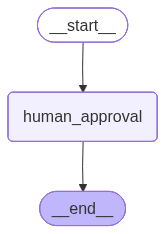

In [14]:
app

In [17]:
config = {"configurable": {"thread_id": "task-123"}}

input_message = [HumanMessage(content="explain supervised learning in simple and short terms")]

result = app.invoke({"messages" : input_message}, config) # type: ignore

In [18]:
result

{'messages': [HumanMessage(content='explain supervised learning in simple and short terms', additional_kwargs={}, response_metadata={}, id='a76a2b25-72d1-4c1e-a842-d2cd4a6138f7')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'explain supervised learning in simple and short terms', 'instruction': 'Approve this question? yes/no'}, id='c17476f75e70e2db9ee122736d903e11')]}

In [19]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'explain supervised learning in simple and short terms',
 'instruction': 'Approve this question? yes/no'}

In [20]:
user_input = input(f"Do you approve? yes/no \n{message} : ")

In [24]:
user_input

'no'

In [21]:
final_result = app.invoke(
	Command(resume={
		"approved": user_input
	}),
	config=config # type: ignore
)

In [22]:
final_result

{'messages': [HumanMessage(content='explain supervised learning in simple and short terms', additional_kwargs={}, response_metadata={}, id='a76a2b25-72d1-4c1e-a842-d2cd4a6138f7'),
  AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='e72f8b03-1456-4b82-bf5a-1c5674eb73fa')]}